<a href="https://colab.research.google.com/github/js2nijjar/deep-learning/blob/main/ARIMAandLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1343]:
# ARIMA

In [1344]:
import pandas as pd

In [1345]:
df = pd.read_csv('CPILFESL.csv')

In [1346]:
df
# CPILFESL - CORE CPI - Price of a theoretical basket of goods excluding food and energy because they are volatile short-term.
# The change in the index reflects inflation.

,observation_date,CPILFESL
0,1995-09-01,162.200
1,1995-10-01,162.700
2,1995-11-01,163.000
3,1995-12-01,163.100
4,1996-01-01,163.700
...,...,...
356,2025-05-01,326.854
357,2025-06-01,327.600
358,2025-07-01,328.656
359,2025-08-01,329.793


In [1347]:
df.set_index('observation_date', inplace=True)

In [1348]:
df

,CPILFESL
observation_date,
1995-09-01,162.200
1995-10-01,162.700
1995-11-01,163.000
1995-12-01,163.100
1996-01-01,163.700
...,...
2025-05-01,326.854
2025-06-01,327.600
2025-07-01,328.656


In [1349]:
df.index.dtype

dtype('O')

In [1350]:
df.index = pd.to_datetime(df.index)

In [1351]:
df.index.dtype

dtype('<M8[ns]')

In [1352]:
df

,CPILFESL
observation_date,
1995-09-01,162.200
1995-10-01,162.700
1995-11-01,163.000
1995-12-01,163.100
1996-01-01,163.700
...,...
2025-05-01,326.854
2025-06-01,327.600
2025-07-01,328.656


<Axes: xlabel='observation_date'>

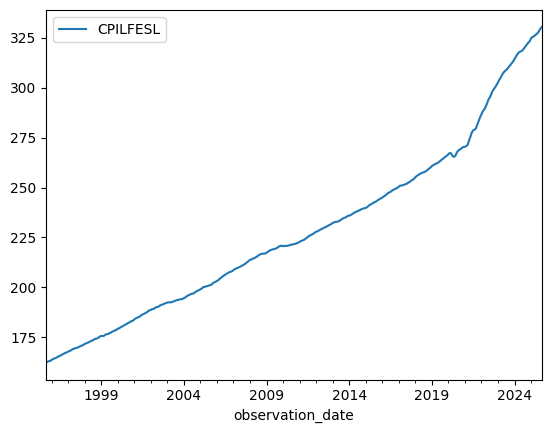

In [1353]:
df.plot()

In [1354]:
import numpy as np

In [1355]:
dflog = np.log(df['CPILFESL'])
# Taking the log of the series to reduce variance.

<Axes: xlabel='observation_date'>

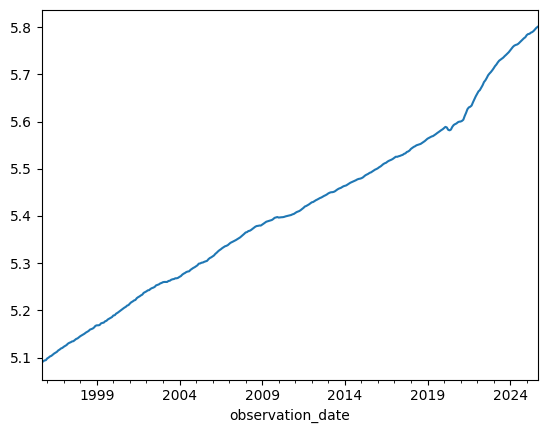

In [1356]:
dflog.plot()

In [1357]:
# Split univariate data into training and testing set. I believe last 12 months is the convention for this type of problem.
split_point = len(dflog) - 12

In [1358]:
dflog_train = dflog[:split_point]
dflog_test = dflog[split_point:]

In [1359]:
dflog_train_1 = dflog_train.diff(1).dropna()

<Axes: xlabel='observation_date'>

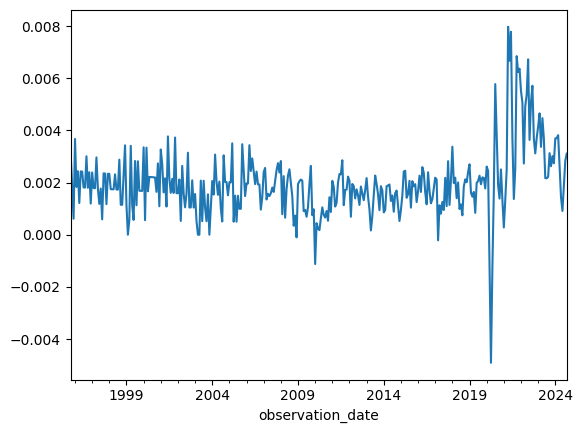

In [1360]:
dflog_train_1.plot()

In [1361]:
from statsmodels.tsa.stattools import adfuller

In [1362]:
adf_test = adfuller(dflog_train_1)
# p-value < 0.05 => stationarity

In [1363]:
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

ADF Statistic: -2.959742068658429
p-value: 0.03882887759105229


In [1364]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

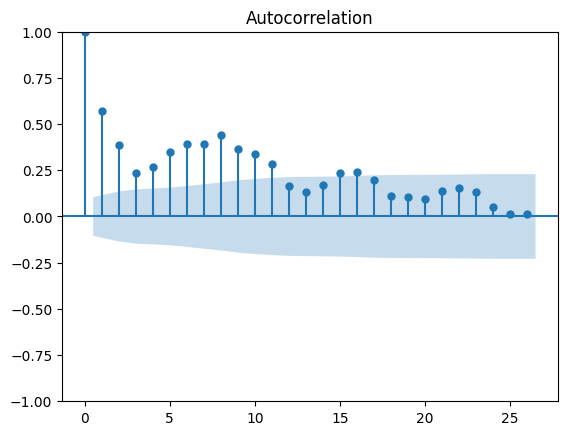

In [1365]:
acf = plot_acf(dflog_train_1)
# ACF decays gradually, significant spike at 1

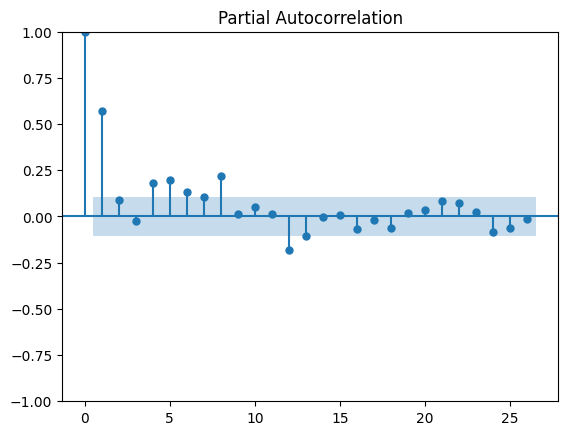

In [1366]:
pacf = plot_pacf(dflog_train_1)
# PACF cuts off after lag 1

In [1367]:
# Try ARIMA(1,1,1) on log(CPI)

In [1368]:
from statsmodels.tsa.arima.model import ARIMA

In [1369]:
model = ARIMA(dflog_train, order=(1,1,1))

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [1370]:
model_fit = model.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [1371]:
print(model_fit.summary())
# CPI depends on the last month and sometimes gets shocked then settles back
# AIC/BIC of ARIMA(1,1,1) lower than ARIMA(1,1,0). ARIMA(1,1,1) better model.
# AR(1) 0.94 last month matters a lot
# MA(1) -0.30 shock corrections exist
# p-values zero both terms matter
# Ljung-Box Prob(Q): 0.33 > 0.05 - errors are random they don't follow a pattern
# meaning the last months error cannot be used to predict the next months error

                               SARIMAX Results                                
Dep. Variable:               CPILFESL   No. Observations:                  349
Model:                 ARIMA(1, 1, 1)   Log Likelihood                1870.568
Date:                Fri, 02 Jan 2026   AIC                          -3735.137
Time:                        01:07:12   BIC                          -3723.580
Sample:                    09-01-1995   HQIC                         -3730.536
                         - 09-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9403      0.017     54.000      0.000       0.906       0.974
ma.L1         -0.2978      0.041     -7.275      0.000      -0.378      -0.218
sigma2      1.248e-06   5.62e-08     22.225      0.0

In [1372]:
# Calculate residuals on training data
# ARIMA captures autocorrelation in a series so after fitting there SHOULD be none left in the residuals
# Check to see if the model has any predicatable pattern

In [1373]:
residauls = model_fit.resid

In [1374]:
residauls[1:]
# With differencing, the first prediction is unstable because the model lacks prior information.

,0
observation_date,
1995-10-01,0.003078
1995-11-01,-0.000851
1995-12-01,-0.001356
1996-01-01,0.002694
1996-02-01,-0.000820
...,...
2024-05-01,-0.001276
2024-06-01,-0.000821
2024-07-01,0.000750


<Axes: xlabel='observation_date'>

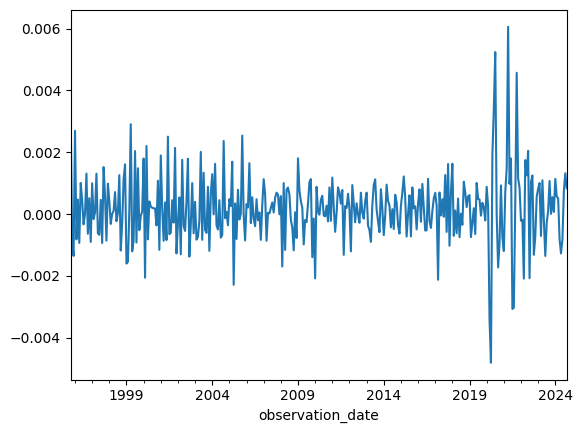

In [1375]:
residauls[1:].plot()
# model captures all patterns only noise left centered around 0 and larger spikes at the end

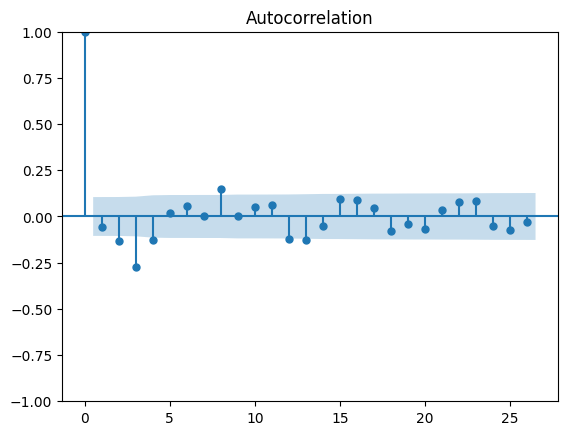

In [1376]:
acf_residauls = plot_acf(residauls[1:])
# correlation between today’s error and past errors? => No

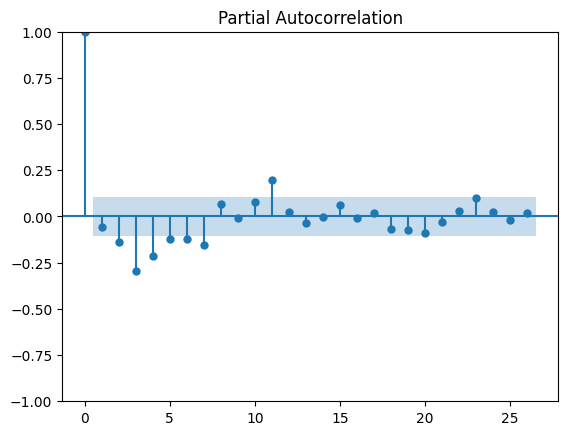

In [1377]:
pacf_residauls = plot_pacf(residauls[1:])
# any direct lag relationship remains? => No

In [1378]:
fitted_values = model_fit.fittedvalues[1:]

<Axes: xlabel='observation_date'>

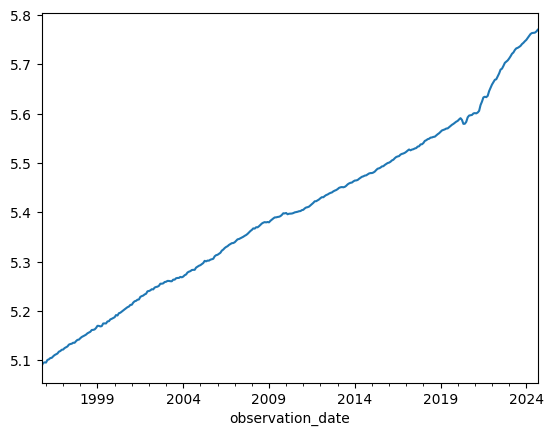

In [1379]:
fitted_values.plot()

In [1380]:
import matplotlib.pyplot as plt

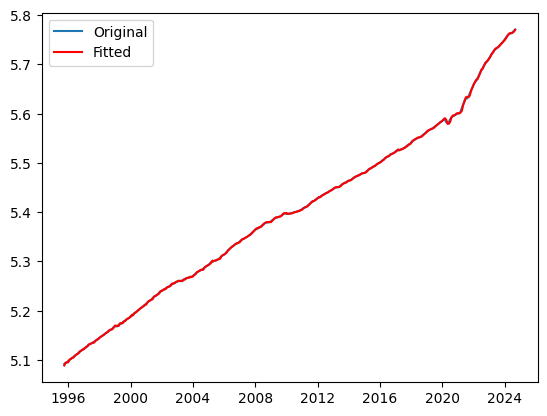

In [1381]:
plt.plot(dflog_train[1:], label='Original')
plt.plot(fitted_values, color='red', label='Fitted')
plt.legend(loc='best')
plt.show()

In [1382]:
# Todays values are dependent on past values plus a shock term so the residuals are close to zero
# and the fitted curve lies on top of the original

In [1383]:
forecast_test = model_fit.forecast(len(dflog_test))

In [1384]:
forecast_test
# ARIMA is a probabilistic model
# Forecasts are distributions because the shocks are normally distributed
# so what you see is the expected value of the distribution

,predicted_mean
2024-10-01,5.773602
2024-11-01,5.776117
2024-12-01,5.778482
2025-01-01,5.780706
2025-02-01,5.782797
2025-03-01,5.784763
2025-04-01,5.786612
2025-05-01,5.788350
2025-06-01,5.789985
2025-07-01,5.791522


In [1385]:
original_forecast_test = np.exp(forecast_test)

In [1386]:
original_forecast_test

,predicted_mean
2024-10-01,321.694362
2024-11-01,322.504508
2024-12-01,323.268139
2025-01-01,323.987819
2025-02-01,324.665987
2025-03-01,325.304953
2025-04-01,325.906912
2025-05-01,326.473942
2025-06-01,327.008012
2025-07-01,327.510988


In [1387]:
df['CPILFESL'].iloc[-12:]

,CPILFESL
observation_date,
2024-10-01,321.688
2024-11-01,322.619
2024-12-01,323.296
2025-01-01,324.739
2025-02-01,325.475
2025-03-01,325.659
2025-04-01,326.430
2025-05-01,326.854
2025-06-01,327.600


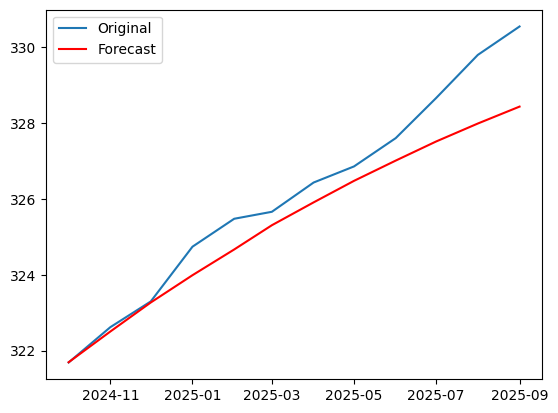

In [1388]:
plt.plot(df['CPILFESL'].iloc[-12:], label='Original')
plt.plot(original_forecast_test, color='red', label='Forecast')
plt.legend(loc='best')
plt.show()

In [1389]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [1390]:
mae = mean_absolute_error(df['CPILFESL'].iloc[-12:], original_forecast_test)

In [1391]:
mae
# On average, forecast is off by 0.72 CPI Index Points per month over the 12-month test period.
# Reasonably accurate given the volatility in recent inflation.

0.7185703986332138

In [1392]:
mse = mean_squared_error(df['CPILFESL'].iloc[-12:], original_forecast_test)

In [1393]:
mse

0.930476266893414

In [1394]:
# LSTM

In [1395]:
# The equivalent of random_state=42 for LSTM
# Makes the results reproducible

import os, random
import numpy as np
import tensorflow as tf

os.environ["PYTHONHASHSEED"] = "0"
random.seed(0)
np.random.seed(0)
tf.keras.utils.set_random_seed(0)

# best-effort determinism (TF 2.13+)
tf.config.experimental.enable_op_determinism()

# also reset TF state so reruns don’t accumulate graph/state
tf.keras.backend.clear_session()


In [1396]:
from sklearn.preprocessing import MinMaxScaler

In [1397]:
scaler = MinMaxScaler(feature_range=(0,1))
# expects an array (rows,features) and scales values between 0 and 1

In [1398]:
df.shape

(361, 1)

In [1399]:
df.values.shape

(361, 1)

In [1400]:
core_cpi_scaled = scaler.fit_transform(df.values)

In [1401]:
# If time_series = [1,2,3,4,5,6] and n_steps = 2, return X = [[1,2], [2,3], [3,4], [4,5]] and y = [3,4,5,6]
# Each row in X contains 2 past values or 2 time steps in a single sample which is n_steps
def split_time_series(time_series, n_steps):
    X, y = list(), list()
    for i in range(len(time_series)):
        end_idx = i + n_steps
        if end_idx > len(time_series) - 1:
            break
        time_series_x, time_series_y = time_series[i:end_idx], time_series[end_idx]
        X.append(time_series_x)
        y.append(time_series_y)
    return np.array(X), np.array(y)

In [1402]:
split_point
# In the function split_time_series, if I use the past 12 months as a split point and 12 timesteps
# there's nothing left so len(time_series) > n_steps
# so I can't use the same split point as I did in ARIMA
# I will use the last 24 months for the test set instead

349

In [1403]:
split_point_24 = split_point - 12

In [1404]:
train, test = core_cpi_scaled[:split_point_24], core_cpi_scaled[split_point_24:]

In [1405]:
len(train), len(test)

(337, 24)

In [1406]:
X_train, y_train = split_time_series(train, 12)

In [1407]:
X_test , y_test = split_time_series(test, 12)

In [1408]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape
# LSTM expects (samples, timesteps, features) but only need to plug in (timesteps, features) for input shape

((325, 12, 1), (325, 1), (12, 12, 1), (12, 1))

In [1409]:
from tensorflow.keras.models import Sequential

In [1410]:
model = Sequential()
# building the model layer by layer

In [1411]:
from tensorflow.keras.layers import LSTM, Dense

In [1412]:
X_train.shape[1], X_train.shape[2]

(12, 1)

In [1413]:
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))
# Each training sample has 12 timesteps. For the first training sample,
# the first input goes into the LSTM cell and you get the long term memory and the hidden state for the first time
# the second input and the previous long term memory and the previous hidden state goes through the same LSTM cell
# and you get the long term memory and the hidden state for the second time
# so in total you have 12 of the same LSTM cells. You get c12 and h12 which have dimensions of 32.
# I tried dimensions 16, 50, 64, 100. 32 had the least mae and mse.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [1414]:
model.add(Dense(1))
# Fully connected layer which takes h12 as input (note c12 is internal and does not leave the LSTM cell)
# apply a weight and bias and the output is 1 dimensional

In [1415]:
model.compile(optimizer='adam', loss='mse')
# predict y_hat, compute (y-y_hat)^2, Adam updates weights in LSTM + Dense to reduce error

In [1416]:
model.fit(X_train, y_train, epochs=50, batch_size=32, shuffle=False)
# epochs - sees training set 50 times
# batch_size - updates weights every 32 samples
# shuffle - don't mix time order

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0562
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0123
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0063
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0184
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0153
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0049
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0037
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.4060e-04
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6270e-04
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2277e-04
Epoch 13/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.7315e-05
Epoch 14/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.4117e-05
Epoch 15/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.250

In [1417]:
y_pred_scaled = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


In [1418]:
y_pred_scaled

array([[0.9464698 ],
       [0.9511912 ],
       [0.9559249 ],
       [0.96057045],
       [0.96546316],
       [0.9702877 ],
       [0.97475064],
       [0.97917855],
       [0.9834553 ],
       [0.987752  ],
       [0.9921653 ],
       [0.9967102 ]], dtype=float32)

In [1419]:
y_pred = scaler.inverse_transform(y_pred_scaled)

In [1420]:
y_pred

array([[321.53064],
       [322.32544],
       [323.1223 ],
       [323.90436],
       [324.728  ],
       [325.5402 ],
       [326.29147],
       [327.0369 ],
       [327.75684],
       [328.48016],
       [329.2231 ],
       [329.9882 ]], dtype=float32)

In [1421]:
y_test = scaler.inverse_transform(y_test)

In [1422]:
y_test

array([[321.688],
       [322.619],
       [323.296],
       [324.739],
       [325.475],
       [325.659],
       [326.43 ],
       [326.854],
       [327.6  ],
       [328.656],
       [329.793],
       [330.542]])

In [1423]:
y_pred.shape, y_test.shape

((12, 1), (12, 1))

In [1424]:
mae = mean_absolute_error(y_test, y_pred)

In [1425]:
mae

0.34190425618489445

In [1426]:
mse = mean_squared_error(y_test, y_pred)

In [1427]:
mse

0.1791246378985926

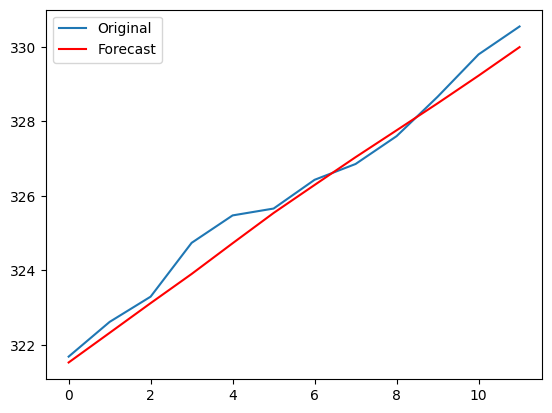

In [1428]:
plt.plot(y_test, label='Original')
plt.plot(y_pred, color='red', label='Forecast')
plt.legend(loc='best')
plt.show()

In [1429]:
forecast_october_arima = np.exp(model_fit.forecast(13)[-1:])
# Forecasting October 2025 via ARIMA
forecast_october_arima

,predicted_mean
2025-10-01,328.850534


In [1430]:
train_october, test_october = core_cpi_scaled[:split_point_24 - 1], core_cpi_scaled[split_point_24 - 1:]
X_train_october, y_train_october = split_time_series(train_october, 12)
X_test_october , y_test_october = split_time_series(test_october, 12)
X_train_october.shape, y_train_october.shape, X_test_october.shape, y_test_october.shape
y_pred_scaled_october = model.predict(X_test_october)
y_pred_october = scaler.inverse_transform(y_pred_scaled_october)
forecast_october_lstm = pd.DataFrame(y_pred_october)[-1:]
forecast_october_lstm.index = ["2025-10-01"]
forecast_october_lstm.columns = ["predicted"]
forecast_october_lstm
# Forecasting October 2025 via LSTM

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


,predicted
2025-10-01,329.98819


In [1431]:
# ARIMA uses a single fixed linear relationship, so it cannot adapt when inflation dynamics change.
# The LSTM uses rolling windows and gating mechanisms, allowing it to condition forecasts on recent
# CPI behavior and respond differently during low- and high-inflation periods.